In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats # We'll need this for the t-test

# Set a random seed so our "random" results are the same every time
np.random.seed(42)

print("Cell 1: Libraries imported.")

Cell 1: Libraries imported.


In [2]:
# Cell 2: The Environment (The "World")

class ReversalBandit:
    """
    A 2-armed bandit task where the reward probabilities flip.
    """
    def __init__(self, reversal_point):
        self.reversal_point = reversal_point
        self.trial_count = 0
        # Phase 1 Probs: Arm 0 is good (80%), Arm 1 is bad (20%)
        self.reward_probs = [0.8, 0.2]
        print(f"World created. Reversal at trial {reversal_point}. Phase 1: Arm 0 is better.")

    def step(self, action):
        """Take an action (0 or 1) and return a reward."""
        
        self.trial_count += 1
        
        # --- Check for Reversal ---
        if self.trial_count == self.reversal_point:
            # Flip the probabilities
            self.reward_probs = [0.2, 0.8]
            # We'll only print this once to avoid clutter
            print(f"*** TRIAL {self.trial_count}: REVERSAL! Arm 1 is now better. ***")
            
        # Get the probability for the chosen action
        prob = self.reward_probs[action]
        
        # Check if this trial is a "win"
        if np.random.rand() < prob:
            return 1  # Return +1 reward
        else:
            return 0  # Return 0 reward

print("Cell 2: Environment 'ReversalBandit' defined.")  

Cell 2: Environment 'ReversalBandit' defined.


In [3]:
# Cell 3: The Agent (The "Brain") - (Stable Tug-of-War)

class MetaAgent: 
    """
    This is our "Stable Tug-of-War" model.
    - "Mood" (meta_state) is a STABLE leaky integrator.
    - "Action" (delta_q_slow) is a POWERFUL "tug-of-war" signal.
    - This model is STABLE because the "action" (delta_q_slow)
      is based on *yesterday's* mood, not today's.
    """
    def __init__(self, meta_mode, lr_fast, lr_meta, meta_strength):
        self.q_values = np.zeros(2)  # [Q(Arm 0), Q(Arm 1)]
        
        # --- Our Model Parameters ---
        self.meta_mode = meta_mode
        self.lr_fast = lr_fast
        self.lr_meta = lr_meta
        self.meta_strength = meta_strength
        self.meta_state = 0.0
        
        self.temperature = 0.1 # Softmax temperature

    def choose_action(self):
        """
        Uses softmax to choose an action probabilistically.
        (With numerical stability fix)
        """
        # 1. Stabilize Q-values (subtract max to prevent overflow)
        stable_q_values = self.q_values - np.max(self.q_values)
        
        # 2. Get Softmax probabilities
        exp_q = np.exp(stable_q_values / self.temperature)
        self.probabilities = exp_q / np.sum(exp_q)
        
        # 3. Choose action (0 or 1) based on probabilities
        action = np.random.choice([0, 1], p=self.probabilities)
        return action
        
    def learn(self, action, reward):
        """
        The "Stable Tug-of-War" learn method.
        """
        
        # --- 1. Calculate "Fast" RPE (The "news") ---
        expected = self.q_values[action]
        delta_fast_rpe = reward - expected
        delta_q_fast = self.lr_fast * delta_fast_rpe
        
        # --- 2. Calculate "Slow" Metaplastic ACTION ---
        #    (Based on *yesterday's* mood)
        delta_q_slow = 0.0
        
        if self.meta_mode:
            # We ONLY act if the "news" is bad
            if delta_fast_rpe < 0:
                # The "Tug-of-War"
                # The "action" is based on the mood *before* today's news.
                delta_q_slow = self.meta_strength * self.meta_state
        
        # --- 3. Final Update (This is now stable) ---
        self.q_values[action] += delta_q_fast + delta_q_slow
        
        # --- 4. Metaplastic "Listening" (Update mood for *tomorrow*) ---
        if self.meta_mode:
            # We ONLY listen to "bad news"
            if delta_fast_rpe < 0:
                # This is the STABLE leaky integrator.
                error = np.abs(delta_fast_rpe) - self.meta_state
                self.meta_state += self.lr_meta * error

print("Cell 3: Agent 'MetaAgent' defined (Stable Tug-of-War model).")

Cell 3: Agent 'MetaAgent' defined (Stable Tug-of-War model).


In [4]:
# Cell 4: The Experiment "Runner" Function

def run_simulation(meta_mode, num_trials, reversal_point, meta_strength, lr_meta, n_runs):
    """
    Runs a full simulation for N_RUNS agents and returns all the data.
    """
    
    all_run_data = []
    
    print(f"  Running {n_runs} simulations...")
    for run in range(n_runs):
        
        # Create a new world and agent for *each* run
        env = ReversalBandit(reversal_point)
        agent = MetaAgent( 
            meta_mode=meta_mode,
            lr_fast=0.1,
            lr_meta=lr_meta,
            meta_strength=meta_strength
        )

        # Logbooks for *this* run
        log_q0 = []
        log_q1 = []
        log_prob0 = []
        log_meta_state = []
        
        for trial in range(num_trials):
            action = agent.choose_action()
            reward = env.step(action)
            agent.learn(action, reward)
            
            # Log the data
            log_q0.append(agent.q_values[0])
            log_q1.append(agent.q_values[1])
            log_prob0.append(agent.probabilities[0]) 
            log_meta_state.append(agent.meta_state)
        
        # Store this run's dataframe
        run_df = pd.DataFrame({
            'run': run,
            'trial': np.arange(num_trials),
            'q_value_arm_0': log_q0,
            'q_value_arm_1': log_q1,
            'choice_prob_arm_0': log_prob0,
            'meta_state': log_meta_state
        })
        all_run_data.append(run_df)
    
    # Return one giant dataframe with all runs
    return pd.concat(all_run_data)

print("Cell 4: Experiment 'Runner' function defined.")

Cell 4: Experiment 'Runner' function defined.


In [5]:
# Cell 5: Run the "Long Run" Experiment

# --- Parameters ---
NUM_TRIALS = 4000       # The long run
REVERSAL_POINT = 200
N_RUNS = 30             # 30 runs for smooth statistical plots
META_LR = 0.5           # (lr_meta) Fast-ish "mood" learning
META_STRENGTH = 0.09    # <-- THE "GOLDILOCKS" PARAMETER

# --- Run 1: The "Healthy" Baseline Model ---
print(f"Running Baseline Model (n={N_RUNS} for {NUM_TRIALS} trials)...")
baseline_data = run_simulation(
    meta_mode=False,
    num_trials=NUM_TRIALS,
    reversal_point=REVERSAL_POINT,
    meta_strength=0.0,
    lr_meta = META_LR,
    n_runs = N_RUNS
)

# --- Run 2: Our "Pathological" Metaplastic Model ---
print(f"\nRunning Metaplastic Model (n={N_RUNS} for {NUM_TRIALS} trials)...")
pathological_data = run_simulation( 
    meta_mode=True,
    num_trials=NUM_TRIALS,
    reversal_point=REVERSAL_POINT,
    meta_strength=META_STRENGTH,
    lr_meta = META_LR,
    n_runs = N_RUNS
)

print("\nSimulations complete. Ready to plot.")

Running Baseline Model (n=30 for 4000 trials)...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World creat

Plotting Figure 1a (0-400 trials) and Figure 1b (0-4000 trials)...


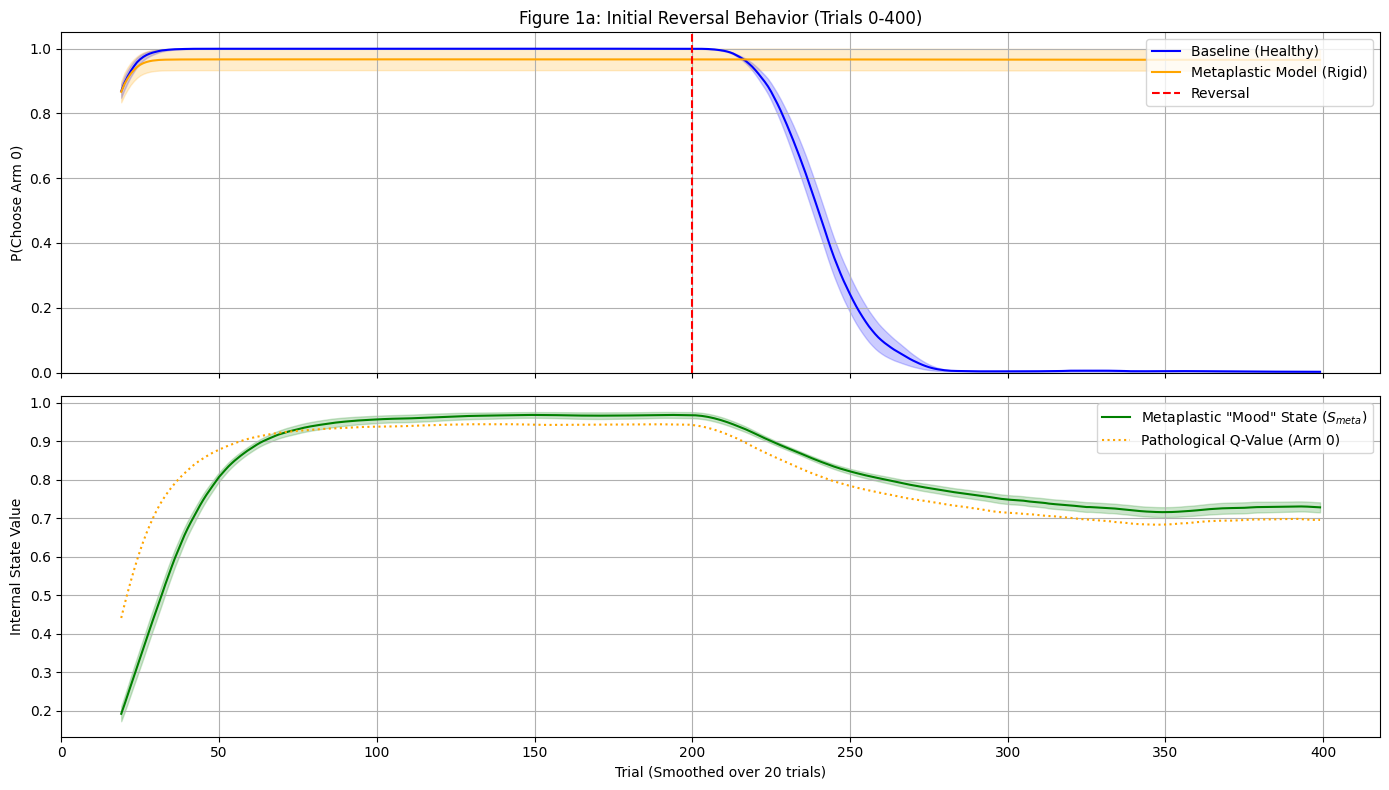

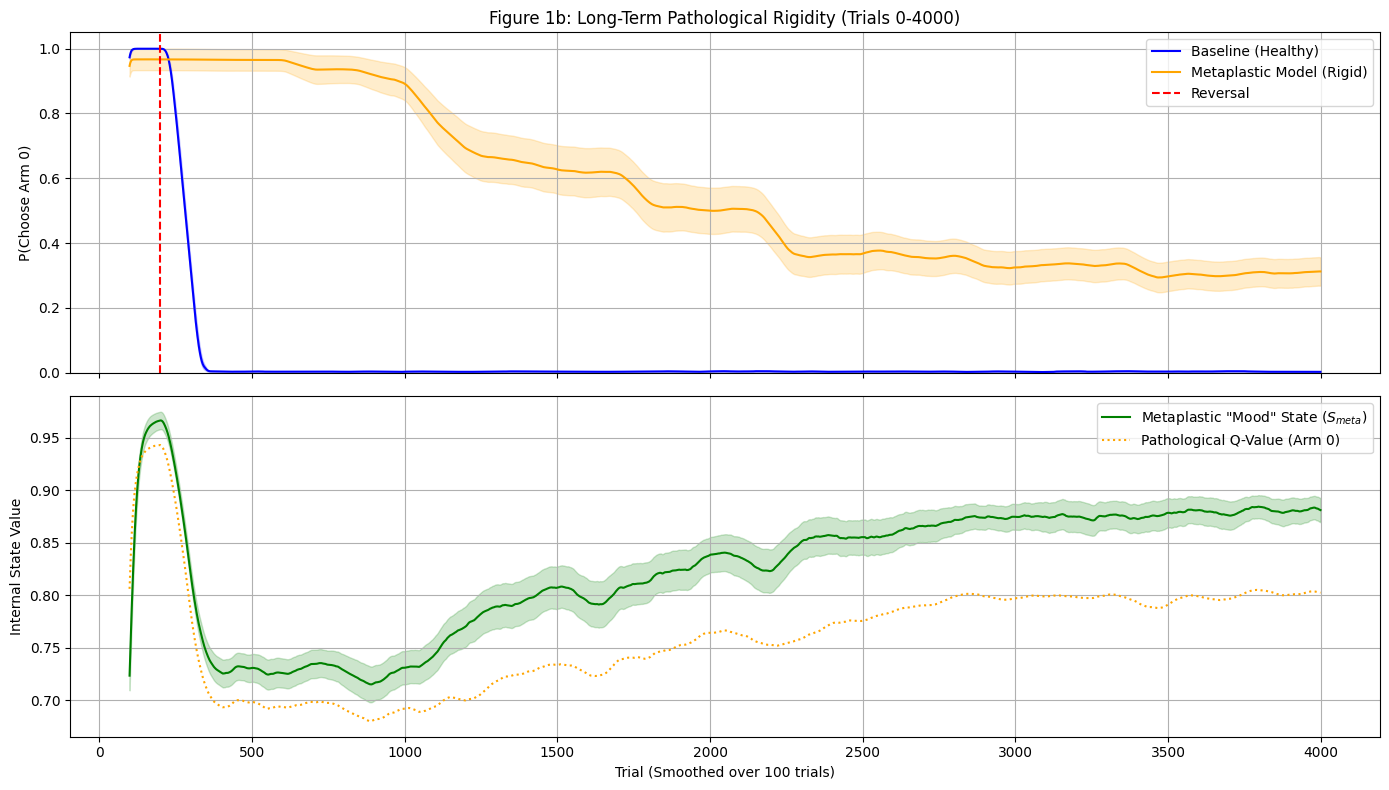

In [6]:
# Cell 6: Plot "Figure 1a" (Short Run) and "Figure 1b" (Long Run)

print("Plotting Figure 1a (0-400 trials) and Figure 1b (0-4000 trials)...")

# --- Parameters for plotting ---
SHORT_TRIALS = 400
LONG_TRIALS = 4000
REVERSAL_POINT = 200
WINDOW_SHORT = 20  # Smoothing for the 400-trial plot
WINDOW_LONG = 100 # Smoothing for the 4000-trial plot

# --- Get the data (we already have this from Cell 5) ---
baseline_mean = baseline_data.groupby('trial')['choice_prob_arm_0'].mean()
baseline_sem = baseline_data.groupby('trial')['choice_prob_arm_0'].sem()
patho_mean = pathological_data.groupby('trial')['choice_prob_arm_0'].mean()
patho_sem = pathological_data.groupby('trial')['choice_prob_arm_0'].sem()
meta_state_mean = pathological_data.groupby('trial')['meta_state'].mean()
meta_state_sem = pathological_data.groupby('trial')['meta_state'].sem()
q0_mean_patho = pathological_data.groupby('trial')['q_value_arm_0'].mean()

#################################################################
# --- PLOT 1: THE "SHORT RUN" (0-400 TRIALS) ---
#################################################################
plt.figure(figsize=(14, 8))

# --- Plot 1a: Choice Behavior (0-400) ---
ax1 = plt.subplot(2, 1, 1)
# Filter the data to only show the first 400 trials
baseline_mean[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Baseline (Healthy)', ax=ax1, color='blue')
patho_mean[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Metaplastic Model (Rigid)', ax=ax1, color='orange')

# Error bars
ax1.fill_between(baseline_mean.index[baseline_mean.index < SHORT_TRIALS],
                 (baseline_mean - baseline_sem)[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (baseline_mean + baseline_sem)[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='blue', alpha=0.2)
ax1.fill_between(patho_mean.index[patho_mean.index < SHORT_TRIALS],
                 (patho_mean - patho_sem)[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (patho_mean + patho_sem)[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='orange', alpha=0.2)

ax1.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax1.set_title(f'Figure 1a: Initial Reversal Behavior (Trials 0-400)')
ax1.set_ylabel('P(Choose Arm 0)')
ax1.legend(loc='upper right')
ax1.grid(True)
ax1.set_ylim(0, 1.05)

# --- Plot 1b: Internal States (0-400) ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1) 
meta_state_mean[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Metaplastic "Mood" State ($S_{meta}$)', ax=ax2, color='green')
q0_mean_patho[q0_mean_patho.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Pathological Q-Value (Arm 0)', ax=ax2, color='orange', linestyle=':')

ax2.fill_between(meta_state_mean.index[meta_state_mean.index < SHORT_TRIALS],
                 (meta_state_mean - meta_state_sem)[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (meta_state_mean + meta_state_sem)[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='green', alpha=0.2)

ax2.set_xlabel(f'Trial (Smoothed over {WINDOW_SHORT} trials)')
ax2.set_ylabel('Internal State Value')
ax2.legend(loc='upper right')
ax2.grid(True)
plt.tight_layout()
plt.show()

#################################################################
# --- PLOT 2: THE "LONG RUN" (0-4000 TRIALS) ---
#################################################################
plt.figure(figsize=(14, 8))

# --- Plot 2a: Choice Behavior (0-4000) ---
ax3 = plt.subplot(2, 1, 1)
baseline_mean.rolling(WINDOW_LONG).mean().plot(label='Baseline (Healthy)', ax=ax3, color='blue')
patho_mean.rolling(WINDOW_LONG).mean().plot(label='Metaplastic Model (Rigid)', ax=ax3, color='orange')

# Error bars
ax3.fill_between(baseline_mean.index,
                 (baseline_mean - baseline_sem).rolling(WINDOW_LONG).mean(),
                 (baseline_mean + baseline_sem).rolling(WINDOW_LONG).mean(),
                 color='blue', alpha=0.2)
ax3.fill_between(patho_mean.index,
                 (patho_mean - patho_sem).rolling(WINDOW_LONG).mean(),
                 (patho_mean + patho_sem).rolling(WINDOW_LONG).mean(),
                 color='orange', alpha=0.2)

ax3.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax3.set_title(f'Figure 1b: Long-Term Pathological Rigidity (Trials 0-4000)')
ax3.set_ylabel('P(Choose Arm 0)')
ax3.legend(loc='upper right')
ax3.grid(True)
ax3.set_ylim(0, 1.05)

# --- Plot 2b: Internal States (0-4000) ---
ax4 = plt.subplot(2, 1, 2, sharex=ax3) 
meta_state_mean.rolling(WINDOW_LONG).mean().plot(label='Metaplastic "Mood" State ($S_{meta}$)', ax=ax4, color='green')
q0_mean_patho.rolling(WINDOW_LONG).mean().plot(label='Pathological Q-Value (Arm 0)', ax=ax4, color='orange', linestyle=':')

ax4.fill_between(meta_state_mean.index,
                 (meta_state_mean - meta_state_sem).rolling(WINDOW_LONG).mean(),
                 (meta_state_mean + meta_state_sem).rolling(WINDOW_LONG).mean(),
                 color='green', alpha=0.2)

ax4.set_xlabel(f'Trial (Smoothed over {WINDOW_LONG} trials)')
ax4.set_ylabel('Internal State Value')
ax4.legend(loc='upper right')
ax4.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Cell 7: The Parameter Sweep Experiment (400 Trials)

print("Cell 7: Defining the Parameter Sweep Experiment...")

# --- Parameters for the Sweep ---
PARAM_N_RUNS = 30
PARAM_TRIALS = 400  # <-- Shorter run for the sweep
PARAM_REVERSAL = 200
PARAM_LR_META = 0.5 # Using our tuned value

beta_strengths = [0, 0.05, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2] # Sweep around our "Goldilocks" value
softmax_temps = [0.1, 0.3] # Test robustness

sweep_results = []

for tau in softmax_temps:
    print(f"\nRunning Sweep for Softmax Temp (τ) = {tau}")
    MetaAgent.temperature = tau # Set class default
    
    for beta in beta_strengths:
        print(f"  Testing Metaplastic Strength (β) = {beta}...")
        
        sim_data = run_simulation(
            meta_mode=True, 
            num_trials=PARAM_TRIALS,
            reversal_point=PARAM_REVERSAL,
            meta_strength=beta,
            lr_meta = PARAM_LR_META,
            n_runs=PARAM_N_RUNS
        )
        
        # --- Quantitative Rigidity Metric (Fix R1) ---
        post_reversal_data = sim_data[sim_data['trial'] > (PARAM_TRIALS - 100)]
        rigidity_per_run = post_reversal_data.groupby('run')['choice_prob_arm_0'].mean()
        mean_rigidity = rigidity_per_run.mean()
        sem_rigidity = rigidity_per_run.sem()
        
        sweep_results.append({
            'tau': tau,
            'beta': beta,
            'mean_rigidity': mean_rigidity,
            'sem_rigidity': sem_rigidity
        })

sweep_df = pd.DataFrame(sweep_results)
MetaAgent.temperature = 0.1 # Reset to default
print("\nParameter sweep complete.")

Cell 7: Defining the Parameter Sweep Experiment...

Running Sweep for Softmax Temp (τ) = 0.1
  Testing Metaplastic Strength (β) = 0...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. P

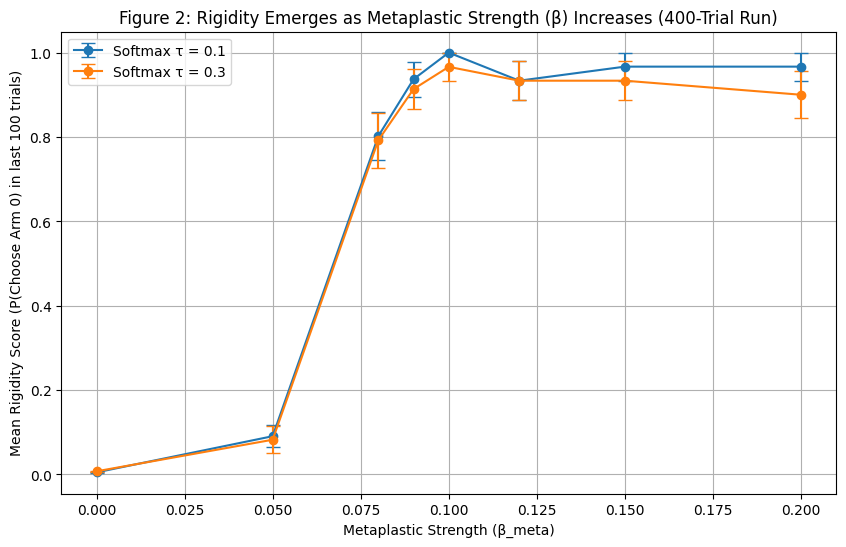


--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---
Mean Rigidity (Baseline, trials 3900-4000):   0.0029
Mean Rigidity (Pathological, trials 3900-4000): 0.3125

Paired T-Test:
  T-statistic = -7.09
  P-value = 8.325240064327083e-08
  Result: The difference is highly statistically significant (p < 0.001).


In [8]:
# Cell 8: Plot Sweep Results & Run T-Test (on Long Run)

# --- 1. Plot the Parameter Sweep "Bifurcation" ---
plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)

for tau in sweep_df['tau'].unique():
    tau_data = sweep_df[sweep_df['tau'] == tau]
    ax.errorbar(
        tau_data['beta'], 
        tau_data['mean_rigidity'], 
        yerr=tau_data['sem_rigidity'],
        label=f'Softmax τ = {tau}',
        marker='o',
        capsize=5
    )

ax.set_title('Figure 2: Rigidity Emerges as Metaplastic Strength (β) Increases (400-Trial Run)')
ax.set_xlabel('Metaplastic Strength (β_meta)')
ax.set_ylabel('Mean Rigidity Score (P(Choose Arm 0) in last 100 trials)')
ax.legend(loc='upper left')
ax.grid(True)
plt.show()

# --- 2. Quantitative T-Test (Fix R1) on 4000-TRIAL RUN ---
from scipy import stats

# We will analyze the *final* 100 trials (e.g., trials 3900-4000)
baseline_post_reversal = baseline_data[baseline_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()
patho_post_reversal = pathological_data[pathological_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()

# Paired t-test
t_stat, p_val = stats.ttest_rel(baseline_post_reversal, patho_post_reversal)

print("\n--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---")
print(f"Mean Rigidity (Baseline, trials 3900-4000):   {baseline_post_reversal.mean():.4f}")
print(f"Mean Rigidity (Pathological, trials 3900-4000): {patho_post_reversal.mean():.4f}")
print(f"\nPaired T-Test:")
print(f"  T-statistic = {t_stat:.2f}")
print(f"  P-value = {p_val}")
if p_val < 0.001:
    print("  Result: The difference is highly statistically significant (p < 0.001).")